In [36]:
import os
import time
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.ndimage.measurements import label
from skimage.feature import hog
import matplotlib
import imageio
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML
import collections

%matplotlib inline
%load_ext line_profiler
matplotlib.rcParams['figure.figsize'] = (10., 8.)
imageio.plugins.ffmpeg.download()


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Reading 17760 images
******************Done extracting features. Time: 102.84933567047119
13320 training images and 6156 features
Fit in 14.18 s
Test acc 0.989


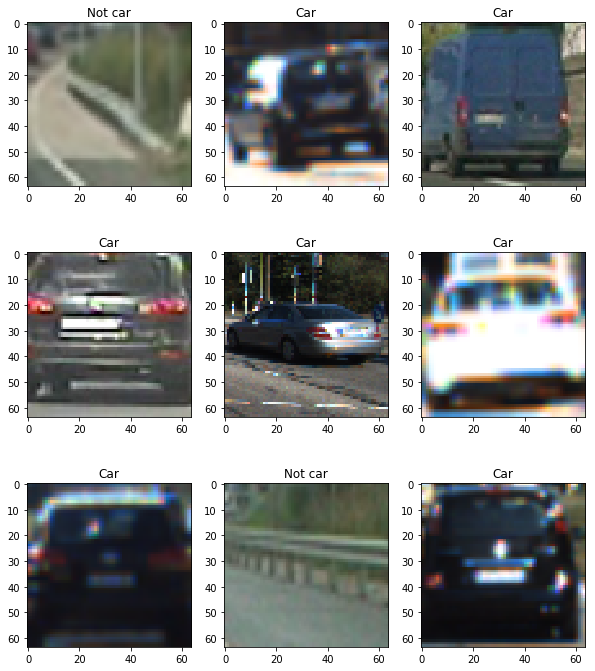

In [46]:
classifier_orig, scaler_orig = train_car_classifier('./data/vehicles/', 
                                          './data/non-vehicles/',
                                          show=True)

In [ ]:
classifier, scaler = train_car_classifier_opencv('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=True)

In [69]:
classifier.best_params_

{'C': 0.1}

Reading 17760 images
******************Done extracting features. Time: 20.98273754119873
X
X_scaler
X_scaled
Train test split
Not grid searching
Fitting
Fit
13320 training images and 6948 features
Fit in 16.76 s
Test acc 0.987


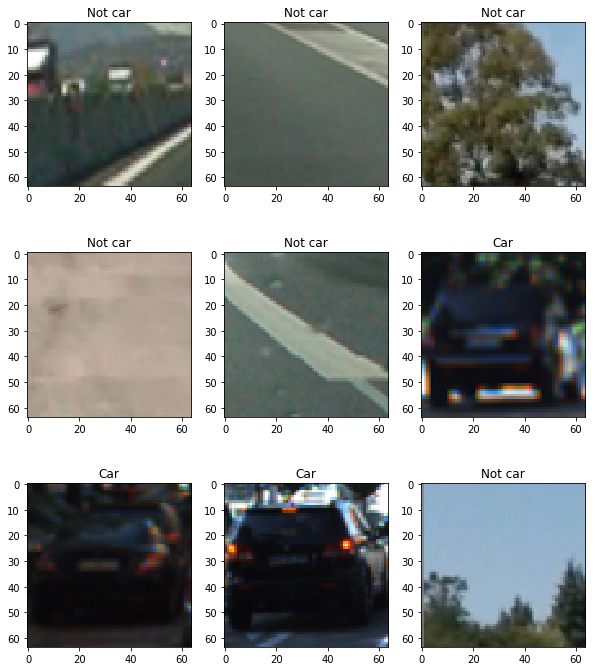

In [427]:
classifier_5, scaler_5 = train_car_classifier_opencv('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=False)

Reading 17760 images
******************Done extracting features. Time: 9.83498215675354
X
X_scaler
X_scaled
Train test split
Not grid searching
Fitting
Fit
13320 training images and 900 features
Fit in 4.37 s
Test acc 0.961


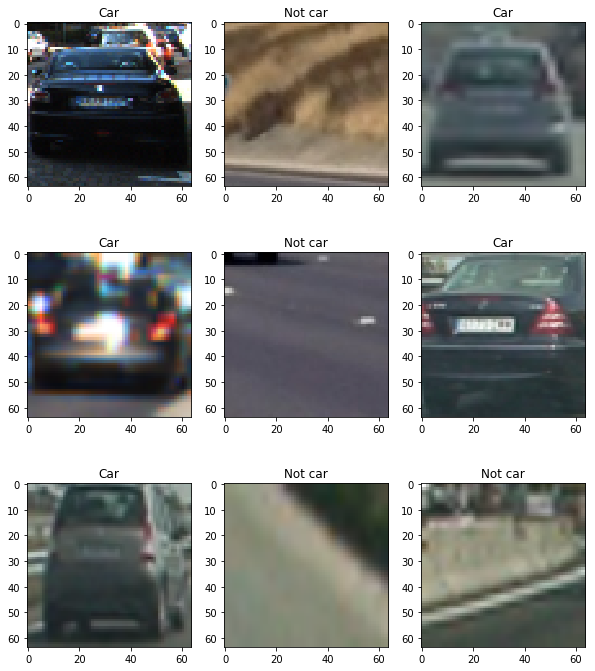

In [500]:
classifier_f, scaler_f = train_car_classifier_faster('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=False)

Reading 17760 images
******************Done extracting features. Time: 13.805361986160278
X
X_scaler
X_scaled
Train test split
Not grid searching
Fitting
Fit
13320 training images and 1668 features
Fit in 3.71 s
Test acc 0.977


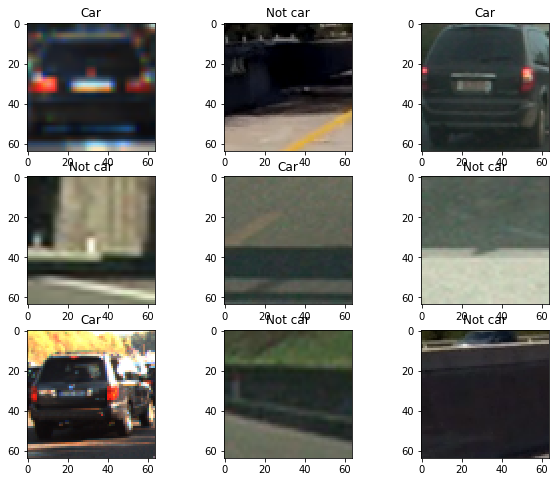

In [22]:
classifier_f1, scaler_f1 = train_car_classifier_faster('./data/vehicles/',
                                                 './data/non-vehicles/',
                                                 show=True,
                                                 grid_search=False)

In [175]:
classifier.best_score_

0.99537828553294161

## Classifier
* Linear SVC classifier used
* HSV color space used
* Spatial binning of color used with a size of 16x16
* Histogram of colors used with 32 bins on only channel 0
* Histogram of gradients used
    * 8 pixels per cell and 2 cells per block
    * Number of orientation bins set to 9 based on this [paper](https://courses.engr.illinois.edu/ece420/fa2017/hog_for_human_detection.pdf) which showed statistically significant increases in performance up to 9 bins.

In [44]:
#------------------80-chars----------------------------------------------------|
def train_car_classifier_faster(veh_path, nonveh_path, grid_search=False, show=False):
    """
    Trains a classifier to recognize cars
    
    :param veh_path: Directory where vehicles images are found
    :param nonveh_path: Directory where non-vehicle images are found
    :param show: Whether to display information about progress and tests set
    :return classifier: A classifier that detects cars
    :return X_scaler: Scaler used to remove mean and scaling of features
    """
    veh_files = retrieve_files(veh_path, 'png')
    nonveh_files = retrieve_files(nonveh_path, 'png')
    img_files = np.hstack((veh_files, nonveh_files))
    labels = np.hstack((np.ones(veh_files.shape[0]), 
                        np.zeros(nonveh_files.shape[0])))
    features = []
    if show:
        print('Reading {0} images'.format(len(img_files)))
    t_i = time.time()
    hog_descr = get_hog_descriptor(pix_per_block=32, pix_per_cell=16, pix_per_step=8)
    for count, img_file in enumerate(img_files):
        if count % 1000 == 0:
            if show:
                print('*', end='')
        img = mpimg.imread(img_file)
        if img.dtype == np.dtype(np.float32):
            img = np.uint8(img*255)
        features.append(get_classifier_features_opencv(img, hog_descr, 
                                                       color_space='YUV', 
                                                       hist_bool=False,
        ))
    t_f = time.time()
    if show:
        print('Done extracting features. Time: {}'.format(t_f - t_i))
    X = np.asarray(features)
    print('X')
    X_scaler = StandardScaler().fit(X)
    print('X_scaler')
    X_scaled = X_scaler.transform(X)
    print('X_scaled')
    X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
        X_scaled, labels, img_files)
    print('Train test split')
    t_i = time.time()
    if grid_search:
        print('Grid searching')
        parameters = {'C':[0.1, 1, 10, 100]} 
        svr = SVC(kernel='linear')
        classifier = GridSearchCV(svr, parameters, scoring='f1', n_jobs=8, verbose=10)
        classifier.fit(X_train, y_train)
        t_f = time.time()
    else:
        print('Not grid searching')
        classifier = LinearSVC(C=0.1)
        print('Fitting')
        classifier.fit(X_train, y_train)
        print('Fit')
    t_f = time.time()
    if show:
        print('{0} training images and {1} features'.format(X_train.shape[0],
                                                            X_train.shape[1]))
        print('Fit in {0:.2f} s'.format(t_f - t_i))
        print('Test acc {0:.3f}'.format(classifier.score(X_test, y_test)))
        for i in range(1, 10):
            test_img = mpimg.imread(img_test[i])
            ax = plt.subplot(3,3,i)
            prediction = classifier.predict(X_test[i].reshape(1, -1))
            if prediction == 1:
                ax.set_title('Car')
            else:
                ax.set_title('Not car')
            ax.imshow(test_img)
        plt.show()
    return classifier, X_scaler

In [6]:
#------------------80-chars----------------------------------------------------|
def retrieve_files(file_folder, file_format):
    """
    Returns an array of all image *files* in a folder with a specified format
    
    :param file_folder: Folder to find images as a string
    :param file_format: File format of the image as a string
    """
    if file_format[0] != '.':
        file_format = '.' + file_format
    image_files = glob.glob(file_folder + '/*/*' + file_format)
    return np.array([file for file in image_files])

In [7]:
#------------------80-chars----------------------------------------------------|
def get_classifier_features_opencv(img, hog_descriptor, hist_bool=True, spatial_bool=True,
                                   hog_bool=True, color_space='RGB', hist_channel=3,
                                   hist_bins=32, spatial_channel=3, hog_channel=3):
    """
    Combine different feature vectors together for each image
    
    :param img: Image to extract features from
    :param hist_bool: Whether or not to include histogram of color features
    :param spatial_bool: Whether or not to include spatial color features
    :param hog_bool: Whether or not to include histogram of gradient features
    :param color_space: Color space to convert features to before extracting
    :param hog_channel: Channel to include in HOG features. 0-1st, 3-all
    :param pix_per_cell: Pixels per hog cell
    :param cells_per_block: Cells ber hog block
    :param orient: Direction bins in histogram for HOG
    :return features: HOG feature vector
    """
    features = []
    height, width, _ = img.shape
    hist_feat = []
    spatial_feat = []
    hog_feat = []
    img = convert_color(img, cspace=color_space)
    #TODO: Loop over image
    if hist_bool:
        hist_feat = color_hist(img, hist_channel, hist_bins)
    if spatial_bool:
        spatial_feat = bin_spatial(img, channel=spatial_channel)
    if hog_bool:
        if hog_channel == 3:
            hog_feat = get_hog_opencv(img, hog_descriptor).squeeze()
        else:
            hog_feat = get_hog_opencv(img[:,:,hog_channel], hog_descriptor).squeeze()
#     print(hist_feat.shape, spatial_feat.shape, hog_feat.shape)
    features = np.hstack((hist_feat, spatial_feat, hog_feat))
    return features

In [8]:
def convert_color(img, cspace='RGB'):
    """
    Converts an RGB image to the given color space
    Available - RGB, BGR, HSV, HLS, YUV, YCC, LUV, LAB
    
    :param img: Image to convert
    :param cspace: Colorspace to convert image to
    """
    
    if cspace == 'RGB':
        return img
    if cspace == 'BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if cspace == 'YCC':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if cspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if cspace == 'LAB':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

In [9]:
def bin_spatial(img, channel=3, size=(16,16)):
    """
    Create feature to represent position of color in space
    
    :param img: Image to extract feature from
    :param size: Size at which to extract features
    """
    spatial_feat = []
    if channel == 0 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,0], size).ravel())
    if channel == 1 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,1], size).ravel())
    if channel == 2 or channel == 3:
        spatial_feat.append(cv2.resize(img[:,:,2], size).ravel())
    return np.hstack(spatial_feat)

In [10]:
#------------------80-chars----------------------------------------------------|
def color_hist(img, channel=3, n_bins=32):
    """
    Create feature vector of an images distribution of colors with histograms
    
    :param img: Image to extract color features from
    :param n_bins: Number of bins to sort pixel intensities into
    """
    hist_feat = []
    if channel == 0 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,0], bins=n_bins)[0])
    if channel == 1 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,1], bins=n_bins)[0])
    if channel == 2 or channel == 3:
        hist_feat.append(np.histogram(img[:,:,2], bins=n_bins)[0])
    return np.hstack(hist_feat)

In [11]:
def get_hog_descriptor(pix_per_win=64, pix_per_block=16, pix_per_step=4, 
                   pix_per_cell=8, n_bins=9):
    """
    Creates a HOG descriptor """
    if not isinstance(pix_per_win, int) or \
        not isinstance(pix_per_block, int) or \
        not isinstance(pix_per_step, int) or \
        not isinstance(pix_per_cell, int) or \
        not isinstance(n_bins, int):
            raise TypeError('HOG Descriptor inputs must be integers. OpenCV error unhelpful')
    return cv2.HOGDescriptor((pix_per_win, pix_per_win),
                             (pix_per_block, pix_per_block),
                             (pix_per_step, pix_per_step),
                             (pix_per_cell, pix_per_cell),
                             n_bins)
    

In [12]:
#------------------80-chars----------------------------------------------------|
def get_hog_opencv(img, hog_descriptor):
    """
    Compute HOG feature vector on image with given HOG descriptor
    
    :param img: Image to compute HOG features on
    :param hog_descriptor: Describes HOG window, block, stride, cell size & bins
    """
    return hog_descriptor.compute(img)

In [93]:
#------------------80-chars----------------------------------------------------|
def get_bounding_boxes(img, classifier, scaler, hog_descr=None, show=False):
    """
    Extract bounding boxes from current frame
    
    :param img: Image to detect cars in
    :return boxes: 4xn nd array of boxes [y_start, y_end, x_start, x_end]
    """
    
    if hog_descr is None:
        hog_descr = get_hog_descriptor()
    boxes = []
#     v_small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, 
#                               hog_descriptor=hog_descr, overlap=0.25,
#                               show=show, y_bounds=(0.525, 0.6), x_bounds=(0, 1.0))
#     if v_small_boxes.size > 0:
#         boxes.append(v_small_boxes)
    
    small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, 
                              hog_descriptor=hog_descr, scale=0.8, overlap=0.2,
                              show=show, y_bounds=(0.525, 0.65), x_bounds=(0, 1.0))
    if small_boxes.size > 0:
        boxes.append(small_boxes)
    
    sm_med_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, 
                              hog_descriptor=hog_descr, scale=0.7, overlap=0.2,
                              show=show, y_bounds=(0.525, 0.7), x_bounds=(0, 1.0))
    if sm_med_boxes.size > 0:
        boxes.append(sm_med_boxes)
        
    med_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, 
                            hog_descriptor=hog_descr,  scale=0.6, overlap=0.2,
                            show=show, y_bounds=(0.55, 0.9))
    if med_boxes.size > 0:
        boxes.append(med_boxes)
    large_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler,
                              hog_descriptor=hog_descr, scale=0.5, overlap=0.25,
                              show=show, y_bounds=(0.55, 1.0))
    if large_boxes.size > 0:
        boxes.append(large_boxes)
    if boxes:
        return np.vstack(boxes)
    else:
        return np.array([])

In [88]:
#------------------80-chars----------------------------------------------------|
def detect_cars(img, classifier, X_scaler, hog_descriptor, scale=1.0,
                       overlap=1.0, show=False, y_bounds=(0.0, 1.0), 
                       x_bounds=(0.0, 1.0)):
    """
    Function tries to detect cars using sliding windows and then returns a list
    of bounding boxes where cars could be.
    
    :param img: Image to detect cars within
    :param classifier: Classifier that determines if a window is a car or not
    :param X_scaler: Scaler used to remove mean and scaling of features
    :param scale: Amount to scale image to get multiple size boxes
    :return bounding_boxes: ndarray of windows where cars detected
    """
    window_size = 64
    orig_height = img.shape[0]
    orig_width = img.shape[1]
    if show:
        draw_img = np.copy(img)
    if scale != 1.0:
        img = cv2.resize(img, (np.int(img.shape[1]*scale), np.int(img.shape[0]*scale)))
    img = cv2.copyMakeBorder(img, 0, 0, 0, window_size, cv2.BORDER_REPLICATE)
    img = convert_color(img, cspace='YUV')
    height = img.shape[0]
    width = img.shape[1]
    bounding_boxes=[]
    step = max(1,int(window_size*overlap))
    count = 0
    y_start = int(y_bounds[0]*height)
    y_end   = int(y_bounds[1]*height) - window_size - 1
    x_start = int(x_bounds[0]*width)
    x_end   = int(x_bounds[1]*width)  - window_size - 1
    for y in range(y_start , y_end, step):
        for x in range(x_start, x_end, step):
            features = []
            count += 1
            pix_window = img[y:y + window_size, x:x + window_size]
#             hist_feat = color_hist(pix_window, channel=3)
#             features.append(hist_feat)
            spatial_feat = bin_spatial(pix_window)
            features.append(spatial_feat)
            hog_feat = get_hog_opencv(pix_window, hog_descriptor).squeeze()
            features.append(hog_feat)
            features = np.hstack(features).reshape(1,-1)
            scaled_features = X_scaler.transform(features)
#             cv2.rectangle(draw_img, (int((x)/scale), 
#                                          int((y)/scale)), 
#                                         (int((x+window_size)/scale), 
#                                          int((y+window_size)/scale)), 
#                                          (255,0, 0), 6)
            if classifier.predict(scaled_features) == 1:
                bounding_box = [max(0, int(y/scale)), 
                                min(orig_height, int((y+window_size)/scale)), 
                                max(0, int(x/scale)), 
                                min(orig_width, int((x+window_size)/scale))]
                bounding_boxes.append(bounding_box)
                if show:
                    cv2.rectangle(draw_img, (int((x)/scale), 
                                         int((y)/scale)), 
                                        (int((x+window_size)/scale), 
                                         int((y+window_size)/scale)), 
                                         (255,0, 0), 6)
                    
    if show:
        img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
        plt.imshow(draw_img)
        plt.show()
        print('Searched {} windows'.format(count))
        print('Found {} boxes'.format(len(bounding_boxes)))
    return np.asarray(bounding_boxes)

In [83]:
small_boxes = detect_cars(img, classifier=classifier_f1, X_scaler=scaler_f1, 
                          hog_descriptor=hog_descr_f1, scale=0.8, overlap=0.2,
                          y_bounds=(0.5, 0.65), x_bounds=(0.3, 1.0))
sm_med_boxes = detect_cars(img, classifier=classifier_f1, X_scaler=scaler_f1, 
                          hog_descriptor=hog_descr_f1, scale=0.7, overlap=0.25,
                          y_bounds=(0.525, 0.7), x_bounds=(0.2, 1.0))
med_boxes = detect_cars(img, classifier=classifier_f1, X_scaler=scaler_f1, 
                        hog_descriptor=hog_descr_f1,  scale=0.6, overlap=0.25,
                        y_bounds=(0.6, 0.85), x_bounds=(0.1, 1.0))
large_boxes = detect_cars(img, classifier=classifier_f1, X_scaler=scaler_f1, 
                          hog_descriptor=hog_descr_f1, scale=0.5, overlap=0.25,
                          y_bounds=(0.7, 1.0))

In [16]:
def add_heat(img, bounding_boxes, show=False):
    heatmap = np.zeros(img.shape[:2])
    for box in bounding_boxes:
        heatmap[box[0]:box[1], box[2]:box[3]] += 1
    if show:
        plt.imshow(heatmap)
        plt.show()
    return heatmap

In [17]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] = 0
    return heatmap

In [18]:
def label_cars(heatmap, show=False):
    labels = label(heatmap)
    if show:
        print('{0} cars found'.format(labels[1]))
        plt.imshow(labels[0], cmap='gray')
        plt.show()
    return labels

In [19]:
def draw_labeled_boxes(img, labels, show=False):
    for car_num in range(1,labels[1]+1):
        nonzero = (labels[0] == car_num).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        bounding_box = ((np.min(nonzero_x), np.min(nonzero_y)),
                        (np.max(nonzero_x), np.max(nonzero_y)))
        cv2.rectangle(img, bounding_box[0], bounding_box[1], (0,0,255), 6)
    if show:
        plt.imshow(img)
        plt.show()
    return img

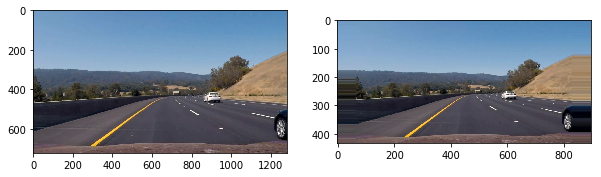

In [91]:
scale=0.6
window_size=64
img = mpimg.imread('/home/bz6w8b/Pictures/vlcsnap-2017-12-14-17h06m48s98.png')
if img.dtype == np.dtype(np.float32):
    img = np.uint8(img*255)
# detect_car_one_frame(img)
ax = plt.subplot(121)
plt.imshow(img)
if scale != 1.0:
    img = cv2.resize(img, (np.int(img.shape[1]*scale), np.int(img.shape[0]*scale)))
img = cv2.copyMakeBorder(img, 0, 0, window_size, window_size, cv2.BORDER_REPLICATE)
ax1 = plt.subplot(122)
plt.imshow(img)
plt.show()

In [87]:
class VehicleDetector:
    def __init__(self):
        self.heatmaps = collections.deque(maxlen=30)
        self.thresh = 8
        self.hog_descr = get_hog_descriptor()
        self.classifier = None
        self.scaler = None
        self.cur_heatmap = np.zeros((720, 1280))
        self.heatmaps.append(self.cur_heatmap)
    def process(self, img, show=False):
        if self.scaler is None or self.classifier is None:
            print('Please set classifier and scaler')
            return None
#         print('Using classifier {}'.format(self.classifier))
#         print('Using scaler {}'.format(self.scaler))
#         print('Using HoG descript {}'.format(self.hog_descr))
        boxes = get_bounding_boxes(img, self.classifier, self.scaler, self.hog_descr)
        if boxes.any():
            self.cur_heatmap = add_heat(img, boxes, show=show)
            self.heatmaps.append(self.cur_heatmap)
            mean_heat = self.cur_heatmap + np.mean(self.heatmaps, axis=0)
            thresh_heatmap = apply_threshold(mean_heat, self.thresh)
            labels = label_cars(thresh_heatmap, show=show)
            final_img = draw_labeled_boxes(img, labels, show=show)
            return final_img
        else:
            return img
    def plot_heatmaps(self, img, show=False):
        if self.scaler is None or self.classifier is None:
            print('Please set classifier and scaler')
            return None
        boxes = get_bounding_boxes(img, self.classifier, self.scaler, self.hog_descr)
        ax0 = plt.subplot(221)
        plt.imshow(img)
        if boxes.any():
            self.cur_heatmap = add_heat(img, boxes, show=show)
            ax1 = plt.subplot(222)
            plt.imshow(self.cur_heatmap)
            self.heatmaps.append(self.cur_heatmap)
            mean_heat = self.cur_heatmap + np.mean(self.heatmaps, axis=0)
            thresh_heatmap = apply_threshold(mean_heat, self.thresh)
            ax2 = plt.subplot(223)
            plt.imshow(thresh_heatmap)
            labels = label_cars(thresh_heatmap, show=show)
            final_img = draw_labeled_boxes(img, labels, show=show)
            ax3 = plt.subplot(224)
            plt.imshow(final_img)
            plt.show()
    def set_thresh(self, thresh):
        self.thresh = thresh
    def set_classifier(self, classifier):
        self.classifier = classifier
    def set_scaler(self, scaler):
        self.scaler = scaler
    def set_hog_descriptor(self, hog_descriptor):
        self.hog_descr = hog_descriptor

In [97]:
i = 7
time_str = np.datetime_as_string(np.datetime64('now'))
challenge_output = 'proj_vid_{0}_{1}.mp4'.format(i, time_str)

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)
hog_descr_f = get_hog_descriptor(pix_per_block=32, pix_per_cell=16, pix_per_step=8)
detector = VehicleDetector()
detector.set_classifier(classifier_f1)
detector.set_scaler(scaler_f1)
detector.set_hog_descriptor(hog_descr_f1)
detector.set_thresh(i)
#                         v_small_boxes = detect_cars(img, classifier=classifier, X_scaler=scaler, 
#                               hog_descriptor=hog_descr, overlap=0.25,
#                               show=show, y_bounds=(0.525, 0.6), x_bounds=(0, 1.0))
#     if v_small_boxes.size > 0:
#     0)
clip1 = VideoFileClip('./project_video.mp4')
challenge_clip = clip1.fl_image(detector.process) #NOTE: this function expects color images!!

video = CompositeVideoClip([challenge_clip])
%time video.write_videofile(challenge_output, audio=False, verbose=False)

100%|█████████▉| 1260/1261 [08:31<00:00,  2.48it/s]


CPU times: user 8min 42s, sys: 14.5 s, total: 8min 57s
Wall time: 8min 31s


In [25]:
img = mpimg.imread('./test_images/test1.jpg')
hog_descr_f1 = get_hog_descriptor(pix_per_block=32, pix_per_cell=16, pix_per_step=8)
%lprun -f detect_cars detect_cars(img, classifier=classifier_f1, X_scaler=scaler_f1, hog_descriptor=hog_descr_f1, scale=1.0, overlap=1.0)#, y_bounds=(0.0,0.7), x_bounds=(0.6,1.))#, x_bounds=(0.2, 1.0))

In [26]:
def detect_car_one_frame(img):
    detector = VehicleDetector()
    detector.set_classifier(classifier_f1)
    detector.set_scaler(scaler_f1)
    detector.set_hog_descriptor(hog_descr_f1)
    detector.set_thresh(15)
    ax0 = plt.subplot(131)
    plt.imshow(img)
    res = detector.process(img)
    ax1 = plt.subplot(132)
    plt.imshow(res)
    ax2 = plt.subplot(133)
    plt.imshow(detector.cur_heatmap)
    plt.show()

In [50]:
def detect_car_one_frame_heatmaps(img):
    detector = VehicleDetector()
    detector.set_classifier(classifier_f1)
    detector.set_scaler(scaler_f1)
    detector.set_hog_descriptor(hog_descr_f1)
    detector.set_thresh(6)
    detector.plot_heatmaps(img)

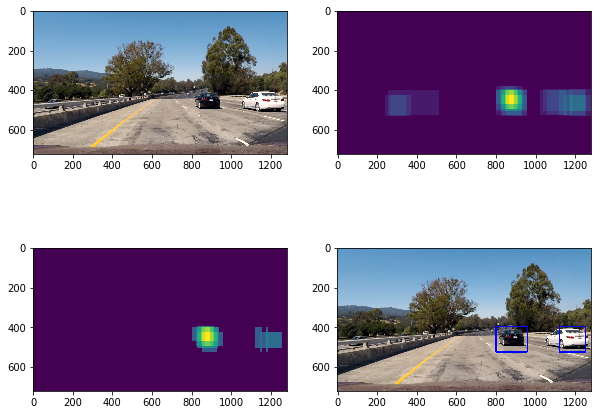

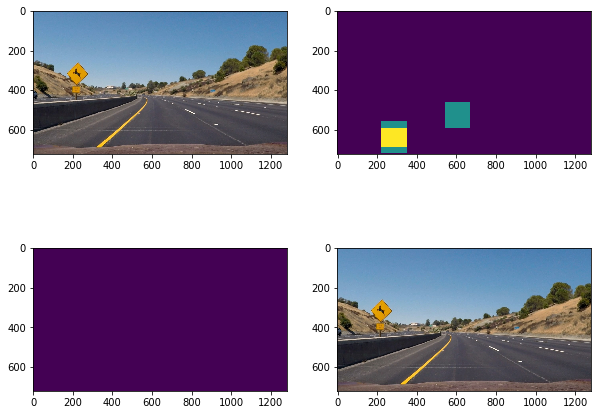

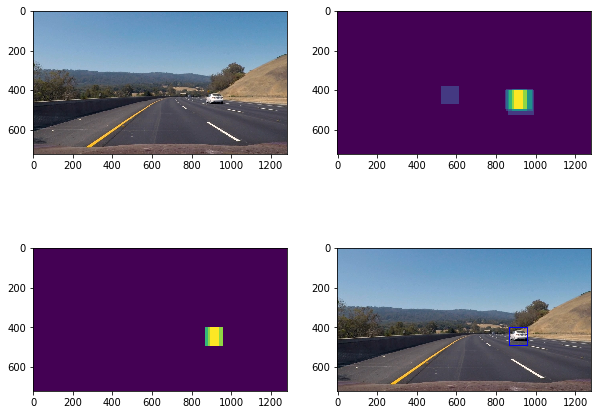

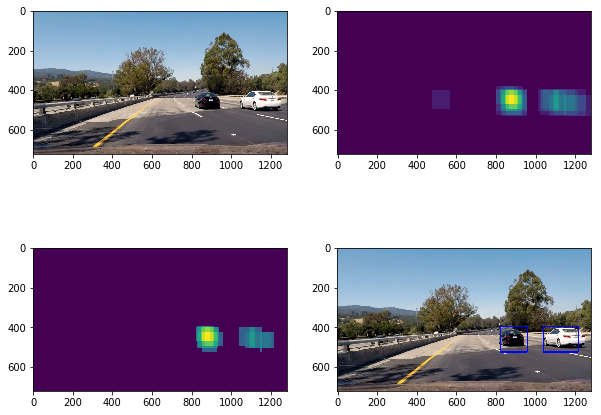

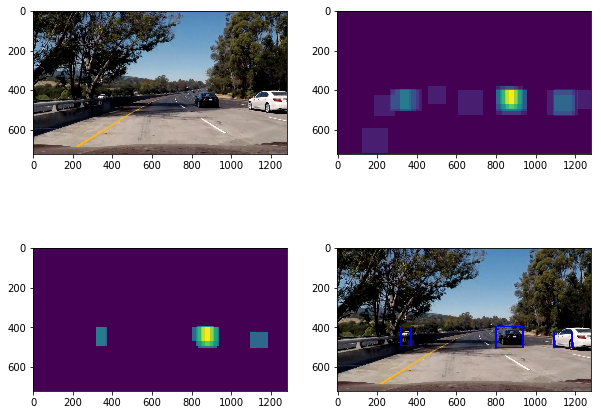

In [53]:
for i in range(1,6):
    img = mpimg.imread('./test_images/test{}.jpg'.format(i))
    detect_car_one_frame_heatmaps(img)
    print('\n\n\n\n\n\n')

In [ ]:
time_str = np.datetime_as_string(np.datetime64('now'))
challenge_output = 'test_vid_{0}_{1}.mp4'.format(8, time_str)

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)
detector = VehicleDetector()
detector.set_classifier(classifier_f1)
detector.set_scaler(scaler_f1)
detector.set_hog_descriptor(hog_descr_f1)
detector.set_thresh(6)
clip1 = VideoFileClip('./test_video.mp4')
challenge_clip = clip1.fl_image(detector.process) #NOTE: this function expects color images!!

video = CompositeVideoClip([challenge_clip])
%time video.write_videofile(challenge_output, audio=False, verbose=False)

In [638]:
def detect_cars_fast(img):
    hog_feat = get_hog_opencv(img, hog_descr_f).T
    windows = np.split(hog_feat, 3234, axis=1)
    count = 0
    for i, window in enumerate(windows):
        scaled_features = scaler_f.transform(window)
        if classifier_f.predict(scaled_features) == 1:
            count += 1

            detector = VehicleDetector()
    print(count)
# detector.set_classifier(classifier_f)
# detector.set_scaler(scaler_f)
# detector.set_hog_descriptor(hog_descr_f)
# detector.set_thresh(1)
# img = mpimg.imread('./test_images/test1.jpg')
# res = detector.process(img)
# plt.imshow(res)
# print(count)